# Single Replica TIS

This notebook shows how to run single replica TIS move scheme. This assumes you can load engine, network, and initial sample from a previous calculation.

In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from openpathsampling.visualize import PathTreeBuilder, PathTreeBuilder
from IPython.display import SVG, HTML

def ipynb_visualize(movevis):
    """Default settings to show a movevis in an ipynb."""
    view = movevis.renderer
    view.zoom = 1.5
    view.scale_y = 18
    view.scale_th = 20
    view.font_size = 0.4
    return view

Open the storage and load things from it.

In [3]:
#old_store = paths.AnalysisStorage("mstis.nc")
old_store = paths.Storage("mstis.nc")  # if not actually doing analysis, but loading network, etc

In [4]:
network = old_store.networks[0]
engine = old_store.engines[0]
template = old_store.snapshots[0]

In [5]:
network.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
network.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
#rate = network.rate_matrix(old_store.steps)

One of the points of SRTIS is that we use a bias (which comes from an estimate of the crossing probability) in order to improve our sampling.

In [6]:
# this is the normal way you'd get this table
#table = {}
#for t in network.sampling_transitions:
#    for ens, lambda_ens in zip(t.ensembles, [0.04, 0.09, 0.15]):
#        table[ens] = t.tcp(lambda_ens)
#for ens in network.special_ensembles['ms_outer'].keys():
#    table[ens] = 0.0
#    for t in network.sampling_transitions:
#        table[ens] += t.tcp(0.25)
#    table[ens] *= len(network.special_ensembles['ms_outer'].keys())
#    # TODO: Justify the math behind that. Also, run it a bunch more times.
    
# However, we usually have a short (bad statistics) run in "mstis.nc"
# Here are results that I got from a 10k MC step run
#desired_table = {
#    "Out A 0" : 1.0,
#    "Out A 1" : 0.13631671445062318,
#    "Out A 2" : 0.024940771341558789,
#    "Out B 0" : 1.0,
#    "Out B 1" : 0.17104343305339545,
#    "Out B 2" : 0.03927673242602249,
#    "Out C 0" : 1.0,
#    "Out C 1" : 0.19353622940592666,
#    "Out C 2" : 0.066440692846493191,
#    "[UnionEnsemble]" : (0.0030508557603910859+0.0087422825961122538+0.017858280680711457)*3
#} # Union is sum of outermost vals for all 3 versions, times the number of versions

# Here are results that I got from a 20k MC step run
desired_table = {
    "Out A 0" : 1.0,
    "Out A 1" : 0.13293104100673198,
    "Out A 2" : 0.044370838092911397,
    "Out B 0" : 1.0,
    "Out B 1" : 0.13846029208307947,
    "Out B 2" : 0.042622152070289694,
    "Out C 0" : 1.0,
    "Out C 1" : 0.19485705066078274,
    "Out C 2" : 0.053373003923696649,
    "[UnionEnsemble]" : (0.021975696374764188 + 0.021955804935886884 + 0.029175949467020165) / 3
} # Union is average of all 3 version, divided by the number of possible initial states (assuming equal prob)


# now we'll set `table` based on `desired_table`
table = {}
my_ensembles = network.sampling_ensembles + network.special_ensembles['ms_outer'].keys()
for ens in my_ensembles:
    table[ens] = desired_table[ens.name]

In [7]:
bias = paths.BiasEnsembleTable.ratios_from_dictionary(table)

In [8]:
bias.df

,Out A 0,Out A 1,Out A 2,Out B 0,Out B 1,Out B 2,Out C 0,Out C 1,Out C 2,[UnionEnsemble]
Out A 0,1,7.5227,22.5373,1,7.22229,23.462,1,5.13197,18.7361,41.0355
Out A 1,0.132931,1,2.99591,0.132931,0.960066,3.11883,0.132931,0.682198,2.4906,5.45489
Out A 2,0.0443708,0.333788,1,0.0443708,0.320459,1.04103,0.0443708,0.22771,0.831335,1.82078
Out B 0,1,7.5227,22.5373,1,7.22229,23.462,1,5.13197,18.7361,41.0355
Out B 1,0.13846,1.04159,3.12052,0.13846,1,3.24855,0.13846,0.710574,2.5942,5.68179
Out B 2,0.0426222,0.320634,0.960589,0.0426222,0.307829,1,0.0426222,0.218735,0.798571,1.74902
Out C 0,1,7.5227,22.5373,1,7.22229,23.462,1,5.13197,18.7361,41.0355
Out C 1,0.194857,1.46585,4.39156,0.194857,1.40731,4.57173,0.194857,1,3.65085,7.99605
Out C 2,0.053373,0.401509,1.20288,0.053373,0.385475,1.25224,0.053373,0.273909,1,2.19019
[UnionEnsemble],0.0243692,0.183322,0.549215,0.0243692,0.176001,0.571748,0.0243692,0.125062,0.456582,1


In [9]:
transAB = network.transitions.values()[4]
ensA0 = transAB.ensembles[0]
ensA1 = transAB.ensembles[1]
print bias.bias_probability(ensA1, ensA0)

0.194857050661


In [10]:
bias.dataframe.loc[2, 7]

0.13846029208307947

In [11]:
for state in network.states:
    print repr(state), repr(state.name)

<openpathsampling.volume.CVRangeVolume object at 0x116f190d0> u'A'
<openpathsampling.volume.CVRangeVolume object at 0x116f19d50> u'B'
<openpathsampling.volume.CVRangeVolume object at 0x116e74d50> u'C'


Here we actually set up the SRTIS move scheme for the given network. It only requires one line:

In [12]:
scheme = paths.SRTISScheme(network, bias=bias, engine=engine)

Now we'll visualize the SRTIS move scheme.

In [13]:
movevis = paths.visualize.MoveTreeBuilder()
#movevis.mover(scheme.move_decision_tree(), network.all_ensembles)
#SVG(ipynb_visualize(movevis).to_svg())

Next we need to set up an appropriate single-replica initial sample set. We'll take the last version of from one of the outer TIS ensembles.

In [14]:
final_samp0 = old_store.steps[len(old_store.steps)-1].active[network.sampling_ensembles[-1]]

In [15]:
sset = paths.SampleSet([final_samp0])

Finally, we set up the new storage file and the new simulation. 

In [16]:
storage = paths.Storage("srtis.nc", "w", template)

In [17]:
srtis = paths.PathSampling(
    storage=storage,
    globalstate=sset,
    move_scheme=scheme
)

In [18]:
n_steps_to_run = int(scheme.n_steps_for_trials(
        mover=scheme.movers['minus'][0], 
        n_attempts=1
    ))
print n_steps_to_run

1230


In [19]:
# logging creates ops_output.log file with details of what the calculation is doing
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [20]:
%%time
multiplier = 10
srtis.run_until(multiplier*n_steps_to_run)

Working on Monte Carlo cycle number 12300.
DONE! Completed 12300 Monte Carlo cycles.
CPU times: user 5min 39s, sys: 28.4 s, total: 6min 7s
Wall time: 6min 4s


In [21]:
storage.close()

From here, we'll be doing the analysis of the SRTIS run.

In [22]:
%%time
storage = paths.AnalysisStorage("srtis.nc")
scheme = storage.schemes[0]

CPU times: user 16.4 s, sys: 850 ms, total: 17.3 s
Wall time: 17.3 s


In [23]:
scheme.move_summary(storage.steps)

ms_outer_shooting ran 14.232% (expected 0.41%) of the cycles with acceptance 139/188 (73.94%)
repex ran 38.986% (expected 3.66%) of the cycles with acceptance 155/515 (30.10%)
shooting ran 23.467% (expected 3.66%) of the cycles with acceptance 227/310 (73.23%)
minus ran 1.741% (expected 0.24%) of the cycles with acceptance 23/23 (100.00%)
pathreversal ran 21.575% (expected 2.03%) of the cycles with acceptance 233/285 (81.75%)


In [24]:
scheme.move_summary(storage.steps, 'shooting')

OneWayShootingMover Out C 0 ran 8.100% (expected 0.41%) of the cycles with acceptance 88/107 (82.24%)
OneWayShootingMover Out C 2 ran 2.801% (expected 0.41%) of the cycles with acceptance 26/37 (70.27%)
OneWayShootingMover Out B 0 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out A 1 ran 1.968% (expected 0.41%) of the cycles with acceptance 21/26 (80.77%)
OneWayShootingMover Out C 1 ran 2.498% (expected 0.41%) of the cycles with acceptance 23/33 (69.70%)
OneWayShootingMover Out A 2 ran 3.785% (expected 0.41%) of the cycles with acceptance 34/50 (68.00%)
OneWayShootingMover Out B 2 ran 2.422% (expected 0.41%) of the cycles with acceptance 18/32 (56.25%)
OneWayShootingMover Out B 1 ran 0.757% (expected 0.41%) of the cycles with acceptance 6/10 (60.00%)
OneWayShootingMover Out A 0 ran 1.136% (expected 0.41%) of the cycles with acceptance 11/15 (73.33%)


In [25]:
scheme.move_summary(storage.steps, 'minus')

SingleReplicaMinus ran 1.514% (expected 0.08%) of the cycles with acceptance 20/20 (100.00%)
SingleReplicaMinus ran 0.000% (expected 0.08%) of the cycles with acceptance 0/0 (nan%)
SingleReplicaMinus ran 0.227% (expected 0.08%) of the cycles with acceptance 3/3 (100.00%)


In [26]:
scheme.move_summary(storage.steps, 'repex')

EnsembleHop Out A 2->[UnionEnsemble] ran 1.968% (expected 0.20%) of the cycles with acceptance 21/26 (80.77%)
EnsembleHop Out B 2->Out B 1 ran 1.363% (expected 0.20%) of the cycles with acceptance 5/18 (27.78%)
EnsembleHop Out A 1->Out A 0 ran 0.757% (expected 0.20%) of the cycles with acceptance 1/10 (10.00%)
EnsembleHop Out B 0->Out B 1 ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop [UnionEnsemble]->Out C 2 ran 7.040% (expected 0.20%) of the cycles with acceptance 15/93 (16.13%)
EnsembleHop [UnionEnsemble]->Out A 2 ran 5.602% (expected 0.20%) of the cycles with acceptance 20/74 (27.03%)
EnsembleHop Out A 2->Out A 1 ran 1.968% (expected 0.20%) of the cycles with acceptance 8/26 (30.77%)
EnsembleHop Out C 1->Out C 2 ran 1.060% (expected 0.20%) of the cycles with acceptance 4/14 (28.57%)
EnsembleHop Out A 1->Out A 2 ran 0.757% (expected 0.20%) of the cycles with acceptance 8/10 (80.00%)
EnsembleHop Out B 1->Out B 0 ran 0.379% (expected 0.20%) of the cyc

In [27]:
scheme.move_summary(storage.steps, 'pathreversal')

PathReversal ran 5.678% (expected 0.20%) of the cycles with acceptance 75/75 (100.00%)
PathReversal ran 7.343% (expected 0.20%) of the cycles with acceptance 97/97 (100.00%)
PathReversal ran 1.363% (expected 0.20%) of the cycles with acceptance 11/18 (61.11%)
PathReversal ran 0.606% (expected 0.20%) of the cycles with acceptance 8/8 (100.00%)
PathReversal ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 1.968% (expected 0.20%) of the cycles with acceptance 25/26 (96.15%)
PathReversal ran 1.438% (expected 0.20%) of the cycles with acceptance 1/19 (5.26%)
PathReversal ran 0.606% (expected 0.20%) of the cycles with acceptance 3/8 (37.50%)
PathReversal ran 2.422% (expected 0.20%) of the cycles with acceptance 12/32 (37.50%)
PathReversal ran 0.151% (expected 0.20%) of the cycles with acceptance 1/2 (50.00%)


In [28]:
replica = storage.samplesets[0].samples[0].replica
ensemble_trace = paths.trace_ensembles_for_replica(replica, storage.steps)
print len(ensemble_trace)

12301


In [29]:
#repex_acceptance = {}
#for mover in scheme.movers['repex']:
#    acceptance = [scheme._mover_acceptance[key] for key in scheme._mover_acceptance if key[0] == mover]
#    repex_acceptance[mover] = acceptance[0]
#
#scheme.build_balance_partners()
#tagged_movers = []
#for mover in repex_acceptance:
#    if mover in tagged_movers:
#        break
#    name = mover.name
#    acceptance = repex_acceptance[mover]
#    acc = float(acceptance[0])/acceptance[1]
#    bp_acceptance = repex_acceptance[scheme.balance_partners[mover][0]]
#    bp_acc = float(bp_acceptance[0])/bp_acceptance[1]
#    in_name = mover.input_ensembles[0].name
#    out_name = mover.output_ensembles[0].name
#    if (desired_table[out_name] > desired_table[in_name]):
#        foo = in_name
#        in_name = out_name
#        out_name = foo
#        foo = acc
#        acc = bp_acc
#        bp_acc = foo
#        
#    out_over_in = desired_table[out_name] / desired_table[in_name]
#    in_over_out = desired_table[in_name] / desired_table[out_name]
#
#    if (in_name, out_name) not in tagged_movers:
#        print "{:.1%} {:.1%} {:.1%} {:s}".format(acc, bp_acc, out_over_in, in_name + "->" + out_name)
#    tagged_movers += [(in_name, out_name)]
    

In [30]:
srtis_ensembles = scheme.network.sampling_ensembles+scheme.network.special_ensembles['ms_outer'].keys()
srtis_ensemble_numbers = {e : srtis_ensembles.index(e) for e in srtis_ensembles}
# this next is just for pretty printing
srtis_numbers_ensemble = {srtis_ensemble_numbers[e] : e for e in srtis_ensemble_numbers}
for k in sorted(srtis_numbers_ensemble.keys()):
    print k, ":", srtis_numbers_ensemble[k].name

0 : Out A 0
1 : Out A 1
2 : Out A 2
3 : Out B 0
4 : Out B 1
5 : Out B 2
6 : Out C 0
7 : Out C 1
8 : Out C 2
9 : [UnionEnsemble]


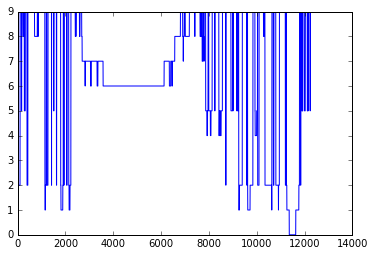

In [31]:
plt.plot([srtis_ensemble_numbers[e] for e in ensemble_trace])

In [32]:
count = 0
for i in range(len(ensemble_trace)-1):
    [this_val, next_val] = [srtis_ensemble_numbers[ensemble_trace[k]] for k in [i,i+1]]
    if this_val == 1 and next_val == 0:
        count += 1
count

1

In [33]:
hist_numbers = [srtis_ensemble_numbers[e] for e in ensemble_trace]
bins = [i-0.5 for i in range(len(srtis_ensembles)+1)]

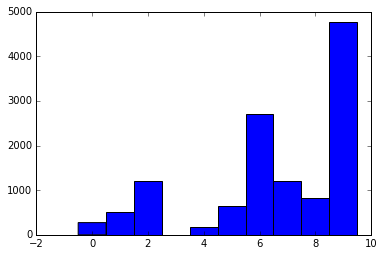

In [34]:
plt.hist(hist_numbers, bins=bins);

In [35]:
import pandas as pd
hist = paths.analysis.Histogram(bin_width=1.0, bin_range=[-0.5,9.5])
colnames = {i : srtis_numbers_ensemble[i].name for i in range(len(srtis_ensembles))}
df = pd.DataFrame(columns=[colnames[i] for i in colnames])

In [36]:
for i in range(len(hist_numbers)):
    hist.add_data_to_histogram([hist_numbers[i]])
    if i % 100 == 0:
        normalized = hist.normalized()
        local_df = pd.DataFrame([normalized.values()], index=[i], columns=[colnames[k] for k in normalized.keys()])
        df = df.append(local_df)

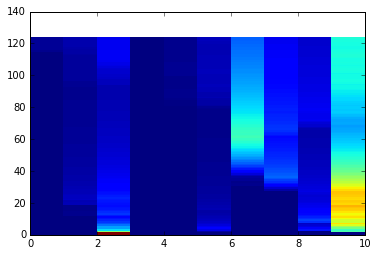

In [37]:
plt.pcolormesh(df.fillna(0.0));